# Дроздов Дмитрий
## Б01-908
---
### № XI.9.6

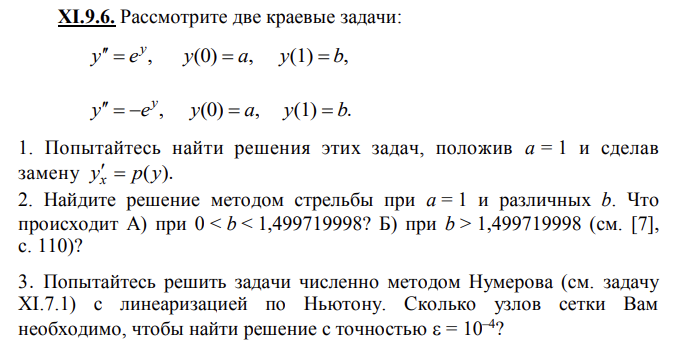

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D

# Метод Ньютона

In [167]:
def diff_v5(func, h, x, xid=0):
  N = len(x)
  h_vec = np.zeros(N)
  h_vec[xid] = h
  return (3 * (func(x + h_vec) - func(x - h_vec)) / (2 * 2 * h) 
          - 3 * (func(x + 2 * h_vec) - func(x - 2 * h_vec)) / (5 * 4 * h) 
          + 1 * (func(x + 3 * h_vec) - func(x - 3 * h_vec)) / (10 * 6 * h))


# численное получение якобиана функции F в точке x
def calc_jacobian(F, x, args=()):
  h = 10**-5
  N = len(x)
  res = np.zeros([N, N])
  for fid in range(0, N):
    for xid in range(0, N):
      func = lambda x: F(x, *args)[fid]
      res[fid, xid] = diff_v5(func, h, x, xid)

  return res


# решение нелинейного уравнения методом Ньютона
def solve(func, x0, eps=10**-4, args=()):
  sol = x0
  iter_counter = 0
  J = calc_jacobian(func, sol, args=args)
  J = np.linalg.inv(J)
  # Для визуалтзации в полне хватает 10 итераций
  # Проверка на невязку убрана в целях повышения производительности
  while(iter_counter < 10):
    F = np.matrix(func(sol, *args))

    sol = np.array((np.matrix(sol).T - J * F.T).T)[0]
    iter_counter += 1
  return sol

## РК

In [148]:
class RungeKutta:
  # matr - матрица метода РК. Матрица состоит из первого столбца - 'С', последней строки - 'в' и все остальное - 'а'
  # t0 - начальное время
  # Y0 - начальные условия
  # F - правая часть системы
  def __init__(self, matr, t0, Y0, F):
    # коэффициенты из матрицы метода
    self.S = len(matr) - 1
    self.C = matr[:self.S, 0].T.tolist()[0]
    self.B = matr[self.S, 1:].tolist()[0]
    self.A = matr[:self.S, 1:]
    self.explicit = RungeKutta.isExplicit(matr)
    # текущее решение (равно начальному)
    self.Y = Y0
    self.DY = F(t0, Y0)
    # текущее время
    self.t = t0
    # правая часть системы
    self.F = F
    # сохраненный след
    self.y_trace = []
    self.dy_trace = []
    for i in range(0, len(self.Y)): 
      self.y_trace.append([]) 
      self.dy_trace.append([])
    self.t_trace = []

    self.SaveTrace()


  # Возвращает True, если matr определяет явный метод РК
  # Иначе False
  def isExplicit(matr):
    N = len(matr)
    for l in range(0, N):
      for c in range(l + 1, N):
        if matr[l, c] != 0:
          return False
    return True


  # dt - шаг
  # explicit - Возможно явно указать какой метод использовать
  def NextStep(self, dt, explicit=None):
    if dt < 0:
      return;
    tmp_exl = self.explicit
    if explicit is True or explicit is False:
      tmp_exl = explicit

    if tmp_exl:
      self.ExplicitNextStep(dt)
    else:
      self.ImplicitNextStep(dt)

    self.t += dt
    self.DY = self.F(self.t, self.Y)
    self.SaveTrace()


  # явный метод РК, полность определяемый матрицей, 
  # переданной в конструктор класса
  def ExplicitNextStep(self, dt):
    if dt < 0:
      return;
    N = len(self.Y)
    # получаем значения K на каждой стадии
    K = [None] * self.S
    YN = self.Y
    for s in range(0, self.S):
      t_s = self.C[s] * dt
      YY = [None] * N
      YY = YN
      for j in range(0, s):
        YY += self.A[s, j] * dt * np.copy(K[j])
      K[s] = self.F(t_s, YY)
    
    # высчитываем y_{n+1}
    for s in range(0, self.S):
      self.Y += dt * self.B[s] * np.copy(K[s]) 


  # решение неявным методом
  def ImplicitNextStep(self, dt):
    if dt < 0:
      return;
    Equation = lambda y_np1: y_np1 - dt * np.copy(self.F(self.t, y_np1)) - np.copy(self.Y)
    self.Y = solve(Equation, x0=np.copy(self.Y))


  # запустить сразу несколько стадин с одинаковым шагом
  def start(self, step, t_end, explicit=None):
      arr = np.arange(self.t, t_end + step, step)
      n = len(arr)

      for i in range(1, n):
        self.NextStep(step, explicit=explicit)


  # сохраняет текущие Y, DY и t в историю (trace)
  def SaveTrace(self):
    for i in range(0, len(self.Y)):
      (self.y_trace[i]).append(self.Y[i])

    for i in range(0, len(self.Y)):
      (self.dy_trace[i]).append(self.DY[i])

    self.t_trace.append(self.t)

## Начальные условия

In [161]:
def F_1(Y):
  return np.exp(Y[1])
def F_2(Y):
  return - np.exp(Y[1])

# y''= e^y
# 
# y' = z    <-> Y[1]
# z' = e^y  <-> exp(Y[0])
# x как аналог времени (в алгоритме РК)
def equat_1(t, Y):
  return [ Y[1], F_1([t, Y[0]]) ]
def equat_2(t, Y):
  return [ Y[1], F_2([t, Y[0]]) ]

a = 1
b = [1.0, 1.5, 3.0, 4.0]

## Результаты для первого уравнения

b =  1.0 ; y' = z =  -1.1455371304277437
b =  1.5 ; y' = z =  -0.8071491296311748
b =  3.0 ; y' = z =  0.034651079125545346
b =  4.0 ; y' = z =  0.43808402079502967


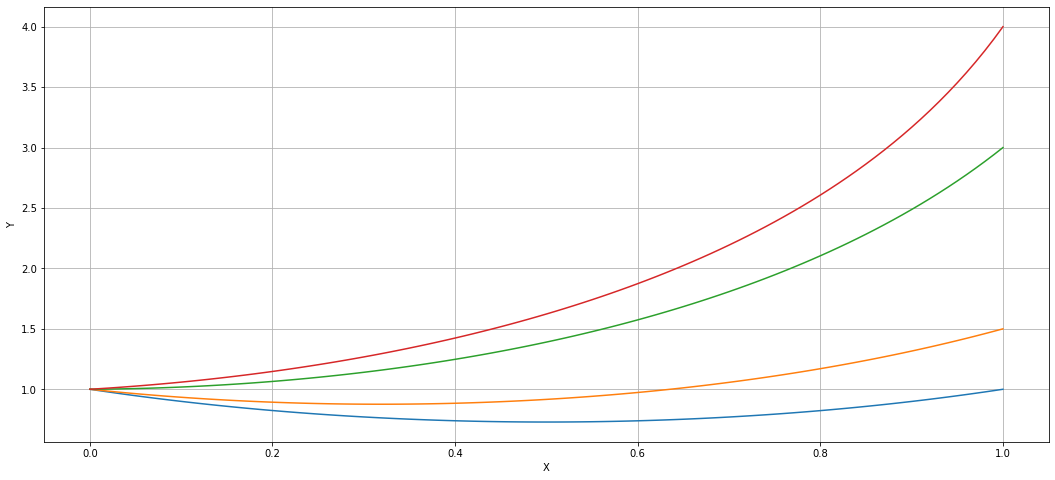

In [163]:
plt.figure(figsize=[18, 8])
plt.grid()
plt.ylabel('Y')
plt.xlabel('t')

for cur_b in b:
  # Функция, для которой ищем нуль.
  # Варьируем направление стрельбы (y' = z).
  def tmp_func(y_shtrih, a, b, equat, rks):
    rk = RungeKutta(np.zeros([2, 2]), 0.0, [a, y_shtrih[0]], equat)
    rk.start(0.01, 1.0, explicit=False)
    # сохраняю выстрел
    rks.append(rk)
    return [rk.y_trace[0][-1] - b]

  # в эту переменную складываются обьекты RungeKutta 
  # "Сохраняю каждый выстрел"
  rks_story = []
  result = solve(tmp_func, x0=[0.0], args=(a, cur_b, equat_1, rks_story))
  plt.plot(rks_story[-1].t_trace, rks_story[-1].y_trace[0])
  print("b = ", cur_b, "; y' = z = ", result[0])

plt.show()


## Результаты для второго уравнения

b =  1.0 ; y' = z =  1.970638607001526
b =  1.5 ; y' = z =  3.789779089104139
b =  2.0 ; y' = z =  25.739698974501394


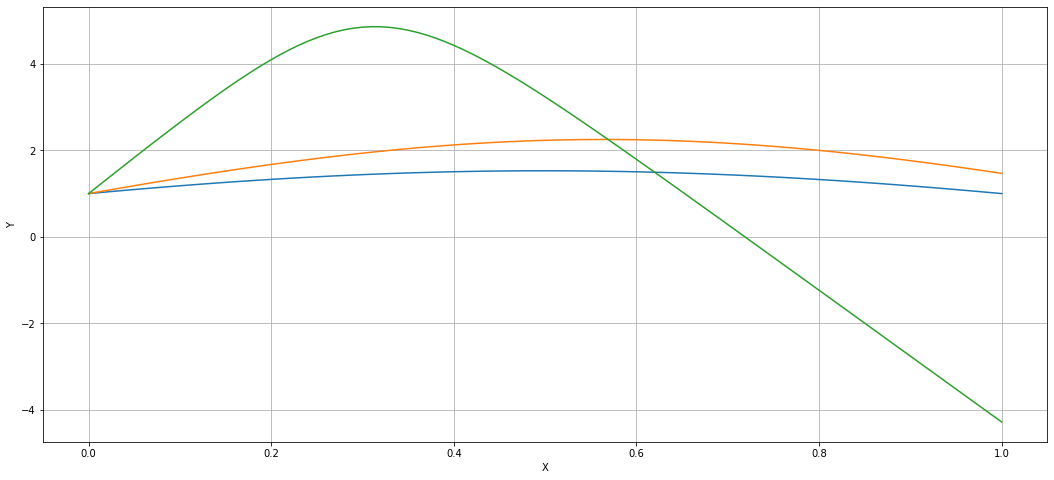

In [166]:
b = [1.0, 1.5, 2.0]


plt.figure(figsize=[18, 8])
plt.grid()
plt.ylabel('Y')
plt.xlabel('t')
for cur_b in b:
  # Функция, для которой ищем нуль.
  # Варьируем направление стрельбы (y' = z).
  def tmp_func(y_shtrih, a, b, equat, rks):
    rk = RungeKutta(np.zeros([2, 2]), 0.0, [a, y_shtrih[0]], equat)
    rk.start(0.01, 1.0, explicit=False)
    # сохраняю выстрел
    rks.append(rk)
    return [rk.y_trace[0][-1] - b]

  # в эту переменную складываются обьекты RungeKutta 
  # "Сохраняю каждый выстрел"
  rks_story = []
  result = solve(tmp_func, x0=[0.0], args=(a, cur_b, equat_2, rks_story))
  plt.plot(rks_story[-1].t_trace, rks_story[-1].y_trace[0])
  print("b = ", cur_b, "; y' = z = ", result[0])
  
plt.show()

При $ b > 1.5 $ задача становится очень неустойчивой